In [1]:
import os
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [82]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

In [56]:
IMAGE_LIB = './Data/'
IMG_HEIGHT, IMG_WIDTH = 128, 128
SEED=42

In [57]:
all_masks = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-6:-4] == '_m']
all_images = []
for i,name in enumerate(all_masks):
    for x in sorted(os.listdir(IMAGE_LIB)):
        if x.startswith(name[:-6]) and x[-6:-4] != '_m':
            all_images.append(x)
            break

In [58]:
x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
for i, name in enumerate(all_images):
    img = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_COLOR).astype('float32')
    im = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_masks), IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
for i, name in enumerate(all_masks):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_COLOR).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT))
    y_data[i] = im

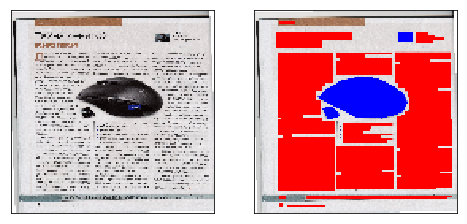

In [59]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].imshow(x_data[0])
ax[1].imshow(y_data[0])
plt.show()

In [60]:
x_data.shape

(101, 128, 128, 3)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

In [64]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [92]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [93]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 128, 128, 8)  224         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_55[0][0]                  
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 64, 64, 16)   1168        max_pooling2d_19[0][0]           
__________________________________________________________________________________________________
max_poolin

In [94]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator().flow(x_train, y=None, batch_size=batch_size, seed=SEED)
    mask_generator = ImageDataGenerator().flow(y_train, y=None, batch_size=batch_size, seed=SEED)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

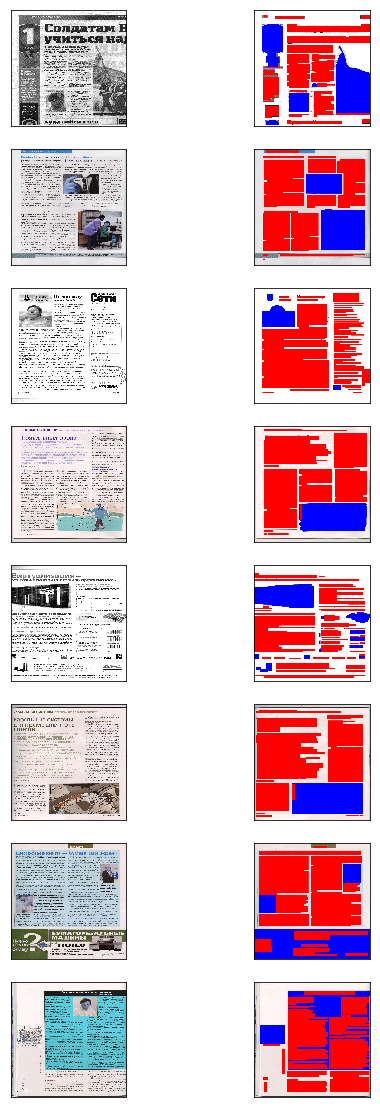

In [95]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_yticks([])
    ax[i,0].imshow(image_batch[i,:,:,:])
    ax[i,1].imshow(mask_batch[i,:,:,:])
plt.show()

In [96]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [97]:
weight_saver = ModelCheckpoint('News.h5', monitor='val_dice_coef', save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
early = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [98]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 100,
                           validation_data = (x_test, y_test),
                           epochs=50, verbose=1,
                           callbacks = [weight_saver, annealer, early])

Epoch 1/50
100/100 [==============================] - 8s 81ms/step - loss: 0.5620 - dice_coef: 0.6353 - val_loss: 0.4406 - val_dice_coef: 0.7301
Epoch 2/50
100/100 [==============================] - 6s 63ms/step - loss: 0.3966 - dice_coef: 0.7692 - val_loss: 0.3692 - val_dice_coef: 0.7871
Epoch 3/50
100/100 [==============================] - 6s 63ms/step - loss: 0.3518 - dice_coef: 0.8002 - val_loss: 0.3545 - val_dice_coef: 0.8059
Epoch 4/50
100/100 [==============================] - 6s 63ms/step - loss: 0.3351 - dice_coef: 0.8112 - val_loss: 0.3569 - val_dice_coef: 0.8077
Epoch 5/50
100/100 [==============================] - 6s 63ms/step - loss: 0.3276 - dice_coef: 0.8153 - val_loss: 0.3559 - val_dice_coef: 0.8137
Epoch 6/50
100/100 [==============================] - 6s 63ms/step - loss: 0.3170 - dice_coef: 0.8219 - val_loss: 0.3539 - val_dice_coef: 0.8178
Epoch 7/50
100/100 [==============================] - 6s 63ms/step - loss: 0.3147 - dice_coef: 0.8234 - val_loss: 0.3523 - val_dic

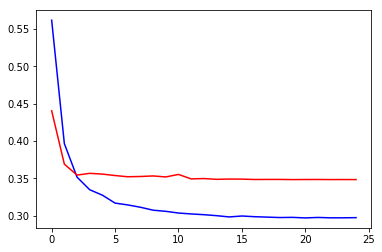

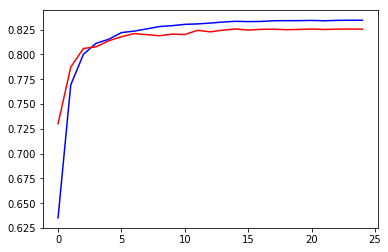

In [99]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

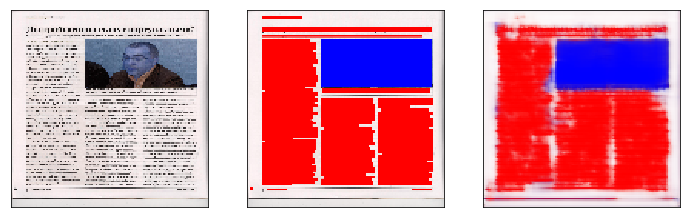

In [109]:
y_hat = model.predict(x_test)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].imshow(x_test[9,:,:,:])
ax[1].imshow(y_test[9,:,:,:])
ax[2].imshow(y_hat[9,:,:,:])